## Experiment: Local Retriever Performance

In this experiment, I measure the retrieval latency of different local and external vectorstores used in our RAG pipeline.  
The goal is to compare the efficiency of different backends when retrieving chunks for the same query, across multiple values of *k*.

### Setup
- **Query:** `"List the main topics in this document"`
- **File:** `./data/eu.pdf` (7 pages, small file → only a few embeddings)
- **Vectorstores tested:** `faiss`, `chroma`, `pinecone`, `weaviate`
- **Embeddings model:** `"sentence-transformers/all-MiniLM-L6-v2"` (HuggingFace)
- **Chunking:**  
  - Splitter: `"recursive"`  
  - Chunk size: `500`  
  - Chunk overlap: `50`
- **Retriever type:** Dense retriever
- **k values tested:** `1, 3, 5, 10, 200`
- **Runs:**  
  - 1 warm-up run (not measured, avoids cold-start bias)  
  - 3 measured runs per `(vectorstore, k)` pair

### Results
For each `(vectorstore, k)` configuration, we recorded:
- **Retrieval time (seconds):** How long it took to fetch documents.  
- **Docs retrieved:** Number of chunks returned per query (expected to be ≤ *k*).  

The results are logged in `experiments/retriever_k_sweep_timings.csv` and can be visualized with Matplotlib.  
This allows us to analyze how retrieval latency scales with increasing *k* and compare performance across vectorstores.


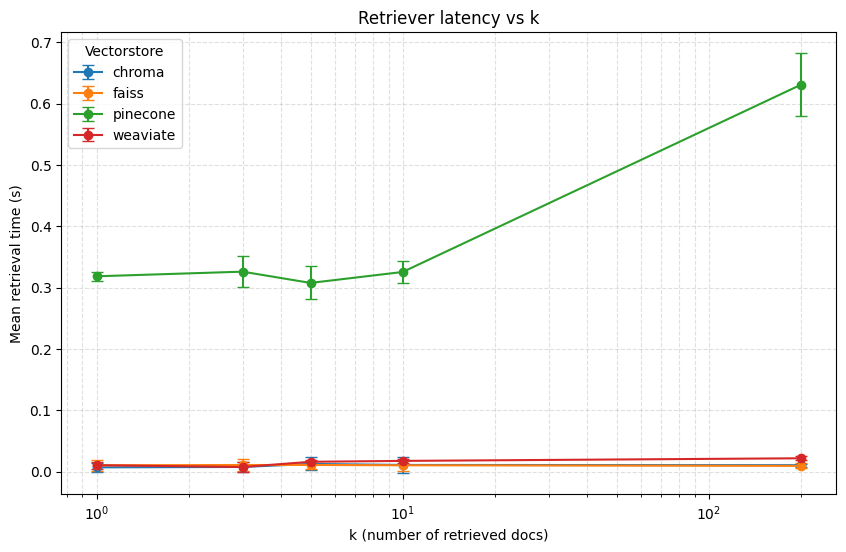

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

csv_path = "../experiments/retriever_k_sweep_timings.csv"
df = pd.read_csv(csv_path)

# compute mean and std per (vectorstore, k)
agg = df.groupby(["vectorstore", "k"])["retrieval_time"].agg(["mean", "std", "count"]).reset_index()

# plot mean retrieval_time vs k for each vectorstore with errorbars
plt.figure(figsize=(10,6))
for vs in agg["vectorstore"].unique():
    subset = agg[agg["vectorstore"] == vs].sort_values("k")
    plt.errorbar(subset["k"], subset["mean"], yerr=subset["std"], marker='o', label=vs, capsize=4)

plt.xscale('log' if max(df["k"]) > 10 else 'linear')  # optional: log x-axis for wide k range
plt.xlabel("k (number of retrieved docs)")
plt.ylabel("Mean retrieval time (s)")
plt.title("Retriever latency vs k")
plt.legend(title="Vectorstore")
plt.grid(True, which="both", ls="--", alpha=0.4)
plt.show()


In this experiment Faiss, Chroma and Weaviate were consistently the fastest (<0.02s), while Pinecone was noticeably slower due to being a cloud-based service, with latency increasing further at very high k (up to ~0.66s for k=200). Only for Pinecone we detected a significant delay increase when k reached 200. Retrieval time generally increased with k. These results reflect only speed, not retrieval quality.

## Experiment: Generator Performance Comparison

In this experiment, I measure the response latency of different LLM generators used in our RAG pipeline.  
The goal is to compare the efficiency of various providers and models when generating answers for the same query.

**Note:** This experiment measures **only the response time** of the generators. It does **not** assess the quality, relevance, or accuracy of the generated answers.


### Setup
- **Query:** `"List the main topics in this document"`
- **File:** `./data/eu.pdf` (7 pages)
- **Vectorstore / Retriever:** Local dense retriever (FAISS), `k=5`
- **Embeddings model:** `"sentence-transformers/all-MiniLM-L6-v2"` (HuggingFace)
- **Chunking:** 
  - Splitter: `"recursive"`
  - Chunk size: `500`
  - Chunk overlap: `50`
- **Generators tested:** Multiple providers and models, including both legacy and latest versions:
  - **OpenAI:** `gpt-5o-mini`, `gpt-4o-mini`, `gpt-4o`
  - **Anthropic:** `claude-opus-4-1-20250805`, `claude-3-7-sonnet-20250219`
  - **Gemini:** `gemini-2.5-flash`
  - **Groq:** `llama-3.3-70b-versatile`
  - **DeepSeek:** `deepseek-chat`
- **Runs:** 
  - 1 warm-up run (not measured, avoids cold start bias)
  - 3 measured runs per generator

### Metrics
- **Response Time (seconds):** Time taken for the generator to produce an answer for the same query.

### Results
- The results are logged in `experiments/generator_timings.csv`.
- For each generator, the **average response time** over measured runs is computed.
- The most important comparison is visualized in a **single bar chart**, showing generator performance across providers and models.

This experiment helps identify the fastest generator models for integration into the RAG pipeline, and allows us to analyze latency differences between legacy and newest LLMs.


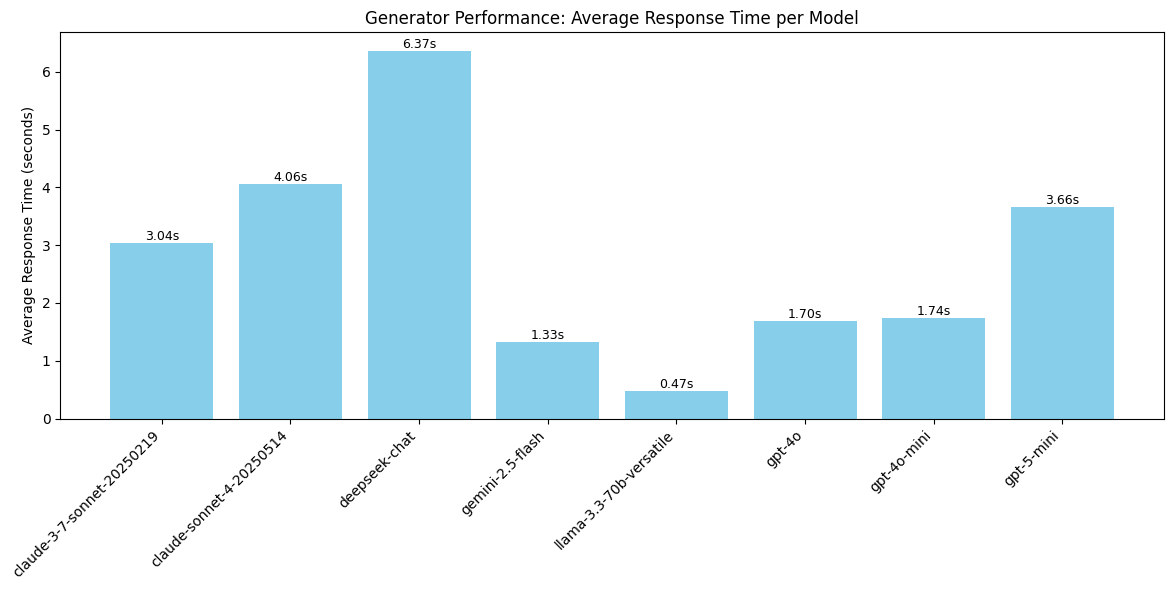

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Load experiment results
csv_path = os.path.join("../experiments", "generator_timings.csv")
df = pd.read_csv(csv_path)

# Compute average response time per model
avg_times = df.groupby(["provider", "model"])["generation_time"].mean().reset_index()

# Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(avg_times["model"], avg_times["generation_time"], color="skyblue")

# Annotate bars with values
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f"{height:.2f}s",
             ha="center", va="bottom", fontsize=9)

plt.xticks(rotation=45, ha="right")
plt.ylabel("Average Response Time (seconds)")
plt.title("Generator Performance: Average Response Time per Model")
plt.tight_layout()
plt.show()


In this experiment, Groq’s `llama-3.3-70b-versatile` was the fastest (~0.47s), benefiting from specialized inference hardware, while DeepSeek’s `deepseek-chat` was the slowest (~6.37s). Among OpenAI models, `gpt-4o` and `gpt-4o-mini` showed lower latency compared to `gpt-5-mini`, and newer Anthropic models performed slightly slower than older ones. Gemini’s `2.5-flash` achieved competitively low latency. These results reflect only **speed** and **not output quality**, making them useful for evaluating real-time performance but not for assessing model accuracy or reasoning ability.
